In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

from sqlalchemy import create_engine, func
from sqlalchemy import Column, Integer, String, Float

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine,reflect=True)


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()
measurement = Base.classes.measurement
station = Base.classes.station
session = Session(engine)

first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f994a812850>,
 'longitude': -157.8168,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US'}

In [8]:
first_row_1 = session.query(measurement).first()
first_row_1.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f994b532110>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1,
 'date': '2010-01-01',
 'tobs': 65.0}

In [9]:
# Save references to each table


In [10]:
# Create our session (link) from Python to the DB


# Exploratory Climate Analysis

<AxesSubplot:title={'center':'plot the data'}>

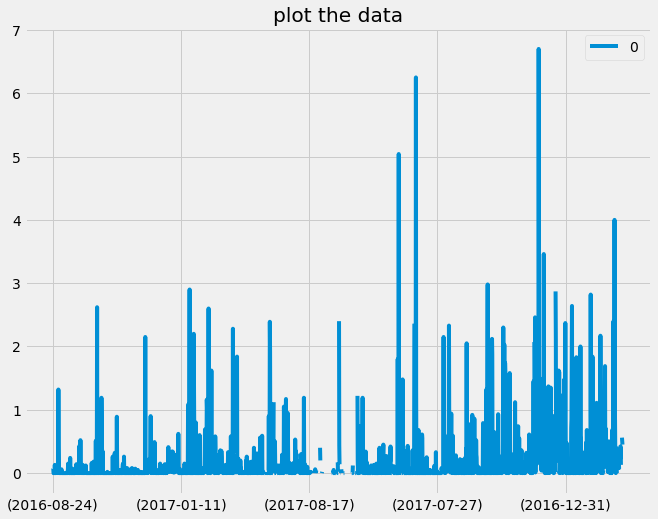

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017,8,23) - dt.timedelta(days=365)
a = session.query(measurement.prcp).filter(measurement.date>='2016-08-23').count()

# Perform a query to retrieve the data and precipitation scores
data_scores = session.query(measurement.prcp).filter(measurement.date>'2016-08-23').all()
date = session.query(measurement.date).filter(measurement.date>'2016-08-23').all()
date = pd.Series(date)

data_scores_df = pd.DataFrame(data_scores)
# data_scores_df.describe()


# Save the query results as a Pandas DataFrame and set the index to the date column
data_scores_df = data_scores_df.set_index(date)
data_scores_df

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
data_scores_df.plot(title="plot the data", figsize=(10,8), legend=True)


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
pd.DataFrame(session.query(measurement.prcp).all()).sum()


0    2908.13
dtype: float64

In [13]:
# Design a query to show how many stations are available in this dataset?
pd.DataFrame(session.query(measurement.station).all()).count()

0    19550
dtype: int64

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
pd.DataFrame(session.query(measurement.station).all()).value_counts().nlargest(1)
# List the stations and the counts in descending order.
pd.DataFrame(session.query(measurement.station).all()).value_counts().sort_values(ascending=False)

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
dtype: int64

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(measurement.tobs)).filter(measurement.station=='USC00519281').one()
session.query(func.max(measurement.tobs)).filter(measurement.station=='USC00519281').one()
session.query(func.avg(measurement.tobs)).filter(measurement.station=='USC00519281').one()

(71.66378066378067,)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

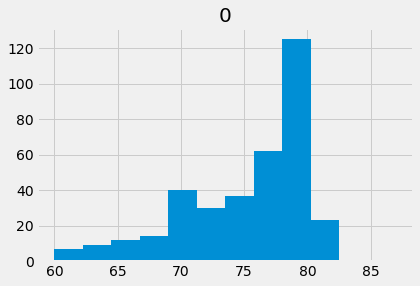

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
session.query(measurement.station, func.max(measurement.tobs)).one()
yearly_temp = session.query(measurement.tobs).filter(measurement.station=='USC00519397').filter(measurement.date>='2016-08-23').all()
yearly_temp=pd.DataFrame(yearly_temp)
yearly_temp.hist(bins=12)

In [17]:
from flask import Flask
app = Flask(__name__)

In [18]:
@app.route("/")
def all():
    return (f"these are all routes")

@app.route("/api/v1.0/precipitation")
# # * Convert the query results to a dictionary using `date` as the key and `prcp` as the value.
def prcp():
    date = session.query(measurement.date).filter(measurement.date>'2016-08-23').all()
    data_scores = session.query(measurement.prcp).filter(measurement.date>'2016-08-23').all()
    prcp_list= []
    for i in range(len(date)):
        prcp_dic = {date[i]:data_scores[i]}
        prcp_list.append(prcp_dic)
    return (prcp_list)

#   * Return a JSON list of stations from the dataset.
@app.route("/api/v1.0/stations")
def stations():
    list_of_station = session.query(station.station)
    return jsonify(list_of_station)

# Query the dates and temperature observations of the most active station for the last year of data.
@app.route("/api/v1.0/tobs")
def tobs():
    tobs_1 = pd.DataFrame(session.query(measurement.station).all()).value_counts().nlargest(1)
    return jsonify(tobs_1)
    
if __name__ == "__main__":
    app.run(debug=True)


    


 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with stat
/Users/tony/opt/anaconda3/envs/bootcamp/lib/python3.7/site-packages/traitlets/traitlets.py:2205: FutureWarning: Supporting extra quotes around strings is deprecated in traitlets 5.0. You can use 'hmac-sha256' instead of '"hmac-sha256"' if you require traitlets >=5.
  FutureWarning)
/Users/tony/opt/anaconda3/envs/bootcamp/lib/python3.7/site-packages/traitlets/traitlets.py:2160: FutureWarning: Supporting extra quotes around Bytes is deprecated in traitlets 5.0. Use '8d639c09-85ce-4f5a-b3bf-5ceb2941274e' instead of 'b"8d639c09-85ce-4f5a-b3bf-5ceb2941274e"'.
  FutureWarning)
Traceback (most recent call last):
  File "/Users/tony/opt/anaconda3/envs/bootcamp/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/tony/opt/anaconda3/envs/bootcamp/lib/python3.7/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.initi

SystemExit: 1

/Users/tony/opt/anaconda3/envs/bootcamp/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
